Import libraries, then read in the file and clean it up.  Drop campaigns which are still in progress.

In [372]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

df = pd.read_csv(r'C:\Users\Michael\OneDrive\Documents\Python\DSI_kickstarterscrape_dataset.csv',encoding='latin1')
indexNames=df[df['status']=='live'].index
df.drop(indexNames,inplace=True)
df = df.replace('Film &amp; Video','Film & Video')

Basic exploratory data analysis on pledged amount.  Store average pledge in pledge_mean.

In [313]:
df['pledged'].describe()

count    4.202800e+04
mean     5.120063e+03
std      5.903152e+04
min      0.000000e+00
25%      2.200000e+02
50%      1.445000e+03
75%      4.397000e+03
max      1.026684e+07
Name: pledged, dtype: float64

In [314]:
pledge_mean = df['pledged'].mean()
pledge_mean

5120.063076996288

Exploratory data analysis and histogram for number of backers.  Note: Some outliers have been removed from the backers data to better visualize the bulk of the data.  The histogram makes it clear that the distribution is skewed to the right (i.e. positive skew).

In [315]:
backers = df[['backers']][df['backers'] <= 100]
backers.describe()

,backers
count,36354.000000
mean,26.495379
std,26.176266
min,0.000000
25%,4.000000
50%,18.000000
75%,42.000000
max,100.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020F525CCB88>]],
      dtype=object)

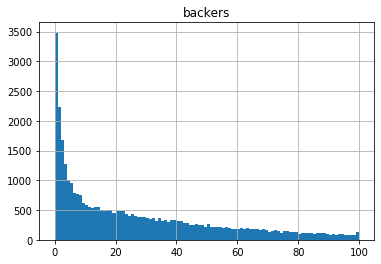

In [316]:
backers.hist(bins=100)

Histogram of the duration variable indicates that the data is not normally distributed.  Rather, the data is concentrated around several "round" values, such as 30, 45, 60, and 90 days.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020F516C9B88>]],
      dtype=object)

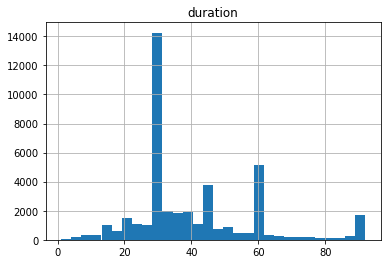

In [317]:
df[['duration']].hist(bins=30)

We examine both the total pledged amount and the funded percentage as a function of the duration (rounded to integer number of days).  Extreme outliers (receiving more than 500 percent backing) have been removed from the data.  We see that, while very short duration leads to the highest funded percentage, campaigns of around 30-50 days do best in terms of overall backing.  This indicates that A) optimal campaigns should last 30-50 days, and B) short campaigns may be setting their pledge goals a bit too low.

In [334]:
indexNames = df[df['funded percentage'] > 5].index
df_test = df[['duration','funded percentage','pledged']].drop(indexNames)
df_test[['duration']] = round(df_test[['duration']])
fundmean = df_test.groupby(['duration'],as_index=False).mean()
fundmean.describe()

,duration,funded percentage,pledged
count,92.00000,92.000000,92.000000
mean,46.50000,0.770637,3649.857724
std,26.70206,0.155447,1488.078375
min,1.00000,0.380392,524.066667
25%,23.75000,0.649276,2629.120826
50%,46.50000,0.774709,3637.163906
75%,69.25000,0.894194,4553.820737
max,92.00000,1.099058,8020.452138


Text(0, 0.5, 'Funded Percentage')

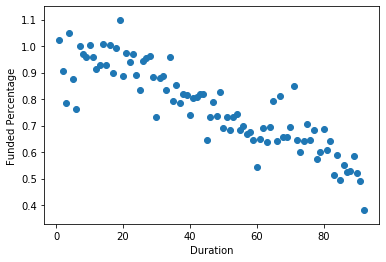

In [351]:
plt.scatter(fundmean['duration'],fundmean['funded percentage'])
plt.xlabel('Duration')
plt.ylabel('Funded Percentage')

Text(0, 0.5, 'Average Total Pledged')

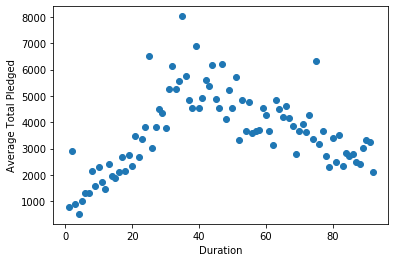

In [350]:
plt.scatter(fundmean['duration'],fundmean['pledged'])
plt.xlabel('Duration')
plt.ylabel('Average Total Pledged')

Considering only at campaigns with duration between 30 and 50 days (which have the best pledge results), we can look at the amount pledged versus the goal (disregarding outliers and binning into \\$1000 increments.  The data indicates that the total pledge increases fairly reliably as the goal goes up, until a limit of around \\$20,000.  Above goals of \\$20,000, the resulting pledge fluctuates wildly, and outcomes become difficult to predict.  As such, the ideal goal for a reliable pledge amount is around \\$20,000.

Text(0, 0.5, 'Average Total Pledged')

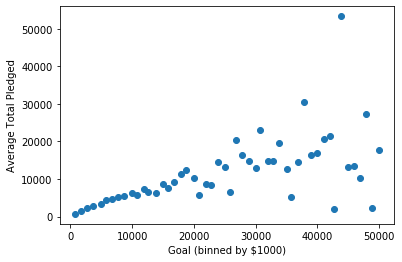

In [349]:
indexNames = df[df['duration'] > 50].index
df_test = df[['duration','goal','funded percentage','pledged']].drop(indexNames)
indexNames = df_test[df_test['duration'] < 30].index
df_test.drop(indexNames,inplace=True)
indexNames = df_test[df_test['goal'] > 50000].index
df_test.drop(indexNames,inplace=True)
indexNames = df_test[df_test['funded percentage'] > 5].index
df_test.drop(indexNames,inplace=True)

bins = np.linspace(0, 50000, 51)
df_test['goal-binned'] = pd.cut(df_test['goal'],bins,include_lowest=True)
binned = df_test.groupby('goal-binned',as_index=False).mean()
binned.head(30)

plt.scatter(binned['goal'],binned['pledged'])
plt.xlabel('Goal (binned by $1000)')
plt.ylabel('Average Total Pledged')

We examine the total number of campaigns and number of funded campaigns in each category.  Dance projects have the highest fraction of funded projects, closely followed by theater and music.

In [373]:
categories = df['category'].value_counts().to_frame()
funded = df['category'][df['funded percentage'] > 1]
funded_count = funded.value_counts().to_frame()
new_categories = categories.merge(funded_count,right_index=True,left_index=True)
new_categories.rename(columns={'category_x':'total', 'category_y':'funded'},inplace=True)
new_categories['fraction'] = new_categories['funded']/new_categories['total']
new_categories.sort_values(by=['fraction'],ascending=False)

,total,funded,fraction
Dance,707,493,0.697313
Theater,2322,1565,0.673988
Music,10062,6534,0.649374
Art,3691,2020,0.547277
Comics,968,510,0.526860
Food,1301,643,0.494235
Film & Video,12619,6129,0.485696
Design,1570,716,0.456051
Photography,1387,620,0.447008
Games,1477,632,0.427894


We first convert the funded date to the start date by subtracting the duration.  Then we extract the month, day, and hour as separate variables.  We examine the percentage of campaigns funded for every month, day of the month, and hour of the day.  The data indicates that one should start their campaign sometime from February to April, at the beginning of the month, sometime in the mid-afternoon (around 3pm).

In [337]:
df['funded date'] = pd.to_datetime(df['funded date'])
df['start date'] = df['funded date'] - pd.to_timedelta(df['duration'],unit = 'D')
df['month'] = pd.DatetimeIndex(df['start date']).month
df['day'] = pd.DatetimeIndex(df['start date']).day
df['hour'] = pd.DatetimeIndex(df['start date']).hour

Text(0, 0.5, 'Fraction Funded')

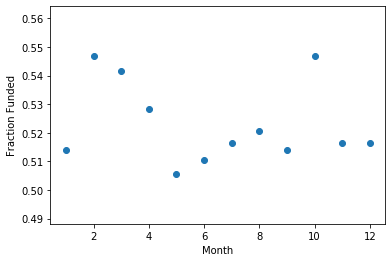

In [343]:
months = df['month'].value_counts().to_frame()
funded = df['month'][df['funded percentage'] > 1]
funded_count = funded.value_counts().to_frame()
new_months = months.merge(funded_count,right_index=True,left_index=True)
new_months.rename(columns={'month_x':'total', 'month_y':'funded'},inplace=True)
new_months['fraction'] = new_months['funded']/new_months['total']
plt.scatter(new_months.index.values,new_months['fraction'])
plt.xlabel('Month')
plt.ylabel('Fraction Funded')

Text(0, 0.5, 'Fraction Funded')

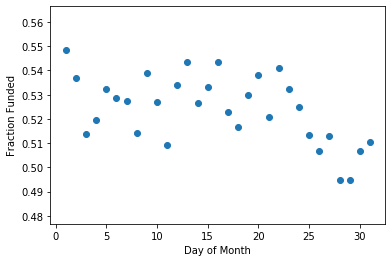

In [344]:
days = df['day'].value_counts().to_frame()
funded = df['day'][df['funded percentage'] > 1]
funded_count = funded.value_counts().to_frame()
new_days = days.merge(funded_count,right_index=True,left_index=True)
new_days.rename(columns={'day_x':'total', 'day_y':'funded'},inplace=True)
new_days['fraction'] = new_days['funded']/new_days['total']
plt.scatter(new_days.index.values,new_days['fraction'])
plt.xlabel('Day of Month')
plt.ylabel('Fraction Funded')

Text(0, 0.5, 'Fraction Funded')

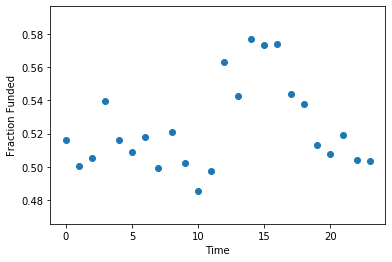

In [345]:
hours = df['hour'].value_counts().to_frame()
funded = df['hour'][df['funded percentage'] > 1]
funded_count = funded.value_counts().to_frame()
new_hours = hours.merge(funded_count,right_index=True,left_index=True)
new_hours.rename(columns={'hour_x':'total', 'hour_y':'funded'},inplace=True)
new_hours['fraction'] = new_hours['funded']/new_hours['total']
plt.scatter(new_hours.index.values,new_hours['fraction'])
plt.xlabel('Time')
plt.ylabel('Fraction Funded')